In [37]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
import fnmatch
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [38]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)
            

In [39]:
class Simulation():
    '''Simulation class stores simulation data relevant for NMRlipids project 6'''
    def __init__(self, dirname, 
                 ordpars_fname="OrdPars.dat", 
                 dens_fname="density_ca_cl_water.xvg", 
                 conc_bulk_fname="conc_ion_bulk_mmolL.dat", 
                 conc_nominal_fname="conc_ion_nominal_mmolL.dat"):
        self.dirname = dirname
        self.ordpars = cop.parse_op_input(os.path.join(dirname, ordpars_fname))
        try:
            self.dens    = np.loadtxt(os.path.join(dirname, dens_fname))
            self.conc_bulk = np.loadtxt(os.path.join(dirname, conc_bulk_fname))
            self.conc_nominal = np.loadtxt(os.path.join(dirname, conc_nominal_fname))
        except:
            print "Simulation in \n {d} \n has no densities or files with concentrations, setting concentrations to 0.".format(d=self.dirname)
            self.conc_bulk = np.zeros([2])
            self.conc_nominal = 0.0
                    

Finding all simulations with ECC-lipids and cationic surfactant

In [40]:
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim22a_0mM" in f and "NaCl" in f and "SPCE" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim22a_" in f and "SPCE" in f and "mM_CaCl-2s" in f and not "smallZ" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()
#print sim_dirs

In [41]:
sims = []
for d in sim_dirs:
    sim = Simulation(d)
    sims.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from ECC-lipids simulations

In [42]:
opsdata = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+p_')  # string pattern for molar fraction in %
for s in sims:
    if "T7H" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata.keys():
            opsdata[opname].extend(temp_list)
        else:
            opsdata[opname] = temp_list
            

print opsdata

0.0 0.01437 0.00111
0.0 0.01381 0.00111
0.0 -0.04397 0.00106
0.0 -0.043 0.00107
0.0 71.78102 0.07989
0.0 -0.16853 0.00088
0.0 -0.18646 0.00082
77.7114019934 -0.00034 0.00078
77.7114019934 -0.00069 0.00078
77.7114019934 -0.04886 0.00075
77.7114019934 -0.05021 0.00075
77.7114019934 70.04352 0.0587
77.7114019934 -0.14462 0.00065
77.7114019934 -0.17439 0.00059
182.889212625 -0.01241 0.00077
182.889212625 -0.00987 0.00077
182.889212625 -0.05389 0.00074
182.889212625 -0.05674 0.00074
182.889212625 68.43371 0.06022
182.889212625 -0.14958 0.00064
182.889212625 -0.17447 0.00059
276.161162791 -0.01642 0.00077
276.161162791 -0.0158 0.00077
276.161162791 -0.05591 0.00074
276.161162791 -0.05556 0.00074
276.161162791 67.3494 0.06029
276.161162791 -0.15612 0.00064
276.161162791 -0.15887 0.00061
392.993421927 -0.02001 0.00076
392.993421927 -0.01683 0.00077
392.993421927 -0.05617 0.00074
392.993421927 -0.05834 0.00074
392.993421927 67.85738 0.06141
392.993421927 -0.15273 0.00064
392.993421927 -0.15641 

Redoing the file search again for the reference simulations set (i.e. Lipid14 + Aqvist ions)

getting PN_vector data from ECC-lipids openMM simulation -- dirty hack here!
---

In [43]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars_omm.dat", root=os.curdir+"/NpT"):
    if "sim22a_0mM" in f and "NaCl" in f and "SPCE" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim22a_" in f and "SPCE" in f and "mM_CaCl-2s" in f and not "MODEL_LIPID14" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()

sims_l14 = []
for d in sim_dirs:
    sim = Simulation(d, ordpars_fname="OrdPars_omm.dat")
    sims_l14.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


In [44]:
opsdata_l14 = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
#p = re.compile('\d+molF')  # string pattern for molar fraction in %
for s in sims_l14:
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14.keys():
            opsdata_l14[opname].extend(temp_list)
        else:
            opsdata_l14[opname] = temp_list
            

print opsdata_l14

0.0 0.01323 0.00064
0.0 0.01166 0.00064
0.0 -0.04441 0.00061
0.0 -0.04621 0.00061
0.0 71.7126 0.04607
0.0 -0.16296 0.00051
0.0 -0.18532 0.00047
276.161162791 -0.01701 0.00063
276.161162791 -0.018 0.00063
276.161162791 -0.05614 0.00061
276.161162791 -0.05762 0.00061
276.161162791 67.70256 0.04929
276.161162791 -0.14339 0.00053
276.161162791 -0.17068 0.00048
816.232890365 -0.03659 0.00061
816.232890365 -0.03307 0.00062
816.232890365 -0.06169 0.0006
816.232890365 -0.0646 0.0006
816.232890365 66.26539 0.0522
816.232890365 -0.13748 0.00053
816.232890365 -0.15635 0.0005
{'alpha2': [[0.0, 0.01166], [276.16116279099998, -0.018], [816.232890365, -0.03307]], 'alpha1': [[0.0, 0.01323], [276.16116279099998, -0.01701], [816.232890365, -0.03659]], 'g3_2': [[0.0, -0.18532], [276.16116279099998, -0.17068], [816.232890365, -0.15635]], 'g3_1': [[0.0, -0.16296], [276.16116279099998, -0.14339], [816.232890365, -0.13748]], 'beta2': [[0.0, -0.04621], [276.16116279099998, -0.05762], [816.232890365, -0.0646]]

Locating and loading Lipid14 + Dang ions simulations

In [45]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim2-3_" in f or "sim0_ref_noIons" in f:
        sim_dirs.append(os.path.dirname(f))

sim_dirs.sort()
#print sim_dirs

sims_l14d = []
for d in sim_dirs:
    sim = Simulation(d)
    sims_l14d.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim0_ref_noIons 
 has no densities or files with concentrations, setting concentrations to 0.


In [46]:
opsdata_l14d = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
#p = re.compile('\d+molF')  # string pattern for molar fraction in %
for s in sims_l14d:
    if "molF" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14d.keys():
            opsdata_l14d[opname].extend(temp_list)
        else:
            opsdata_l14d[opname] = temp_list
            

print opsdata_l14d

0.0 0.06928 0.00077
0.0 0.07021 0.00076
0.0 -0.00241 0.00073
0.0 0.00048 0.00073
0.0 76.79575 0.05124
0.0 -0.17378 0.00055
0.0 -0.23514 0.00049
161.167561462 0.00074 0.00077
161.167561462 -0.00173 0.00077
161.167561462 -0.03721 0.00075
161.167561462 -0.04146 0.00075
161.167561462 67.83188 0.06174
161.167561462 -0.12664 0.00065
161.167561462 -0.16689 0.0006
589.637973422 -0.05558 0.00073
589.637973422 -0.04821 0.00074
589.637973422 -0.05486 0.00074
589.637973422 -0.06368 0.00073
589.637973422 60.4994 0.06119
589.637973422 -0.11615 0.00066
589.637973422 -0.12024 0.00063
{'alpha2': [[0.0, 0.07021], [161.16756146200001, -0.00173], [589.63797342199996, -0.04821]], 'alpha1': [[0.0, 0.06928], [161.16756146200001, 0.00074], [589.63797342199996, -0.05558]], 'g3_2': [[0.0, -0.23514], [161.16756146200001, -0.16689], [589.63797342199996, -0.12024]], 'g3_1': [[0.0, -0.17378], [161.16756146200001, -0.12664], [589.63797342199996, -0.11615]], 'beta2': [[0.0, 0.00048], [161.16756146200001, -0.04146], [

getting experimental results from Scherer89

In [47]:
exp_filenames = []
experiments = {}
freq_to_scd = 0.00748

# DPPC experiments
# find files with the experimental values as read from figure4 in scherer89
for f in locate("EXP-Akutsu1981*CaClchange-T323.dat", root=os.curdir+"/../../../../lipid_ionINTERACTION/Data"):
    exp_filenames.append(f)

exp_data = np.loadtxt(exp_filenames[0], dtype=str)
# convert col1 to contain S_CD with a correct sign -- this is specific to these data
# convert col0 to contain concentrations in %-unit
experiments['beta_DPPC']  = exp_data[:,0:-1]
experiments['alpha_DPPC'] = exp_data[:,[0,2]]

# POPC experiments    
for f in locate("EXP-Altenbach1984-T313K.dat", root=os.curdir+"/../../../../lipid_ionINTERACTION/Data/POPC/CaCl"):
    exp_data = np.loadtxt(f, dtype=str, usecols=[0,1])
    # convert col1 to contain S_CD with a correct sign -- this is specific to these data
    # convert col0 to contain concentrations in %-unit
    experiments['alpha_POPC'] = exp_data

for key in experiments.keys():
    templist = []
    for item in experiments[key]:
        if not item[1]=='-':
            fitem = np.array(item, dtype=float)
            freq_sign = 1.0
            f_conc = 1.0
            if 'beta' in key:
                freq_sign = -1.0
            if 'alpha_POPC' in key:
                f_conc = 1000.0
            templist.append([fitem[0]*f_conc, fitem[1]*freq_to_scd*freq_sign])
    experiments[key] = np.array(templist, dtype=float)
    
print experiments
        

{'beta_DPPC': array([[  0.00000000e+00,  -0.00000000e+00],
       [  3.50000000e+02,  -1.69048000e-02],
       [  1.00000000e+03,  -2.00464000e-02]]), 'alpha_POPC': array([[  0.00000000e+00,   4.56280000e-02],
       [  5.00000000e+00,   4.30848000e-02],
       [  1.00000000e+01,   4.12896000e-02],
       [  2.00000000e+01,   3.97936000e-02],
       [  5.00000000e+01,   3.76244000e-02],
       [  1.00000000e+02,   3.39592000e-02],
       [  2.00000000e+02,   2.99200000e-02],
       [  4.00000000e+02,   2.34124000e-02],
       [  5.00000000e+02,   2.04204000e-02],
       [  6.00000000e+02,   1.78772000e-02],
       [  8.00000000e+02,   1.45860000e-02],
       [  1.00000000e+03,   9.87360000e-03],
       [  2.00000000e+03,   0.00000000e+00],
       [  3.00000000e+03,  -1.49600000e-02],
       [  4.00000000e+03,  -2.48336000e-02],
       [  5.00000000e+03,  -2.88728000e-02]]), 'alpha_DPPC': array([[  0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+01,  -8.22800000e-03],
       [ 

# Plotting figure 1: PN_vector and order parameters $\alpha$ and $\beta$ depend on the amount of bound charge - cationic surfactant

# Plotting figure 2: PN_vector and order parameters $\alpha$, $\beta$, and $g_3$ depend on the amount of bound charge - cationic surfactant

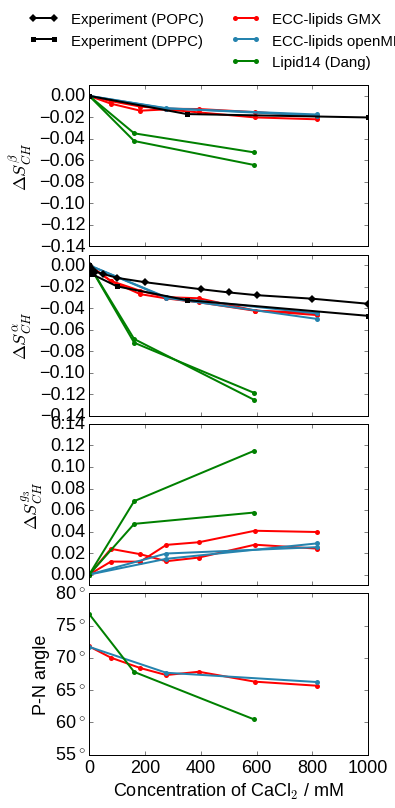

In [48]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=4, ncols=1, 
                        sharex="all", figsize=[5,12], 
                        dpi=200)
fig.subplots_adjust(hspace=0.05)

#fig.subplotpars.left = 0.3

# give subplots human-redable names
dsa = axs[1] # Delta S alpha
dsb = axs[0] # Delta S beta
dsg = axs[2] # Delta S g_3
pna = axs[3] # PN_vector

# add some text for labels, title and axes ticks
pna.set_xlabel(r'Concentration of CaCl$_2$ / mM')
pna.set_ylabel(r'P-N angle')
dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')
dsg.set_ylabel(r'$\Delta S_{CH} ^{g_3}$')

#pna.set_xlim([0.0,60.0])
#ax.set_xticks(r1)
#xlabelsl = list(xlabels)
#xlabelsl.extend(range(2, 18))
#ax.set_xticklabels(xlabelsl, rotation=0)

for (opsplot, c, label) in zip([opsdata, opsdata_l14, opsdata_l14d, experiments], 
                               ["red", "#2583AE", "green", "black"], 
                               ["ECC-lipids GMX", ur"ECC-lipids openMM", "Lipid14 (Dang)", "Experiment"]):
    for key in opsplot.keys():
        yerror = 0.001
        do_delta = False
        if key.startswith("alpha"):
            iplt = 1
            do_delta = True
            ylim = [-0.14, 0.01]
        elif key.startswith("beta"):
            iplt = 0
            do_delta = True
            ylim = [-0.14, 0.01]
        elif key.startswith("g3"):
            iplt = 2
            do_delta = True
            ylim = [-0.01, 0.14]
        elif key.startswith("PN"):
            iplt = 3
            yerror = 0.15
            ylim = [55.0, 80.0]
        else:
            print "this should not happen, setting iplt = 2"
            iplt = 2
        ax = axs[iplt]
        ax.set_ylim(ylim)
        if isinstance(opsplot[key], list):
            opsplot[key].sort()
        else:
            #print "this is not list, not sorting. It's likely the experimental data."
            pass
        data = np.array(opsplot[key])
        if do_delta:
            data[:,1] -= data[0,1]
        #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
        if key.startswith("alpha_") or key=="alpha1":
            plot_label = label
            if key.endswith("PC"):
                plot_label += " ("+key[key.rfind("_")+1:]+")"
        else:
            plot_label = None
        marker = "o"
        markersize = 5
        if "POPC" in key:
            marker = "D"
        if "DPPC" in key:
            marker = "s"
        ax.plot(data[:,0], data[:,1], lw=2.0, marker=marker, markersize=markersize, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)

        
for ax in axs:
    #ax.minorticks_on()
    pass
    
#xlim = pna.get_xlim()
#pna.set_xticks(range(0,90,20))
#pna.set_xticklabels([ str(i)+r"%" for i in range(0,90,20)])
pna.set_xlim([0,1000])

ylim = pna.get_ylim()
pna.set_yticks(range(0,90,5))
pna.set_yticklabels([ str(i)+r"$^\circ$" for i in range(0,90,5)])
pna.set_ylim(ylim)

#dsb.legend(loc="lower left", markerscale=1.0, scatterpoints=4, fontsize='x-small')
dsa.legend(bbox_transform=plt.gcf().transFigure,
           bbox_to_anchor=(0.48, 1.0), 
           ncol=2, mode="expand",
           frameon=False,
           fontsize='small')

plt.savefig("PN_angle_OrdPars-A-B-g3_L14-ECCL17_q80_sig89_CaCl_GMX-oMM_compar.pdf", dpi=200, bbox_inches='tight')
plt.show()
